### Custom unitary gate approach (5 March)  

Overleaf documentation: https://www.overleaf.com/project/636d711f81310b0cd8b37e65 

TODO: New Lindbladian from Kvam paper



#### Code overview
1) Compute Lindbladian operator L

2) Function definitions (measurement, build_propagator, check_unitary, make_circuit)

3) Time evolution calculation

In [80]:
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.tools.visualization import plot_histogram
from scipy.linalg import expm

#### 1. Simulation constants

In [81]:
#Lindblad equation from 2022 paper (eq. 3)
delta = 1.0   # Default 1, 1, 1
gamma = 1.5  
Omega = 3.0

#### 2. Function definitions

##### 2.1 Lindbladian generation from Kvam et al. Nature paper
$$ \mathcal{L}(\rho) = \sum_{i,j} \gamma_{ij} \left( L_{ij} \bullet \rho \bullet L_{ij}^\dagger - \frac{1}{2} \{ {L_{ij}^\dagger \bullet L_{ij}, \rho}  \} \right) $$

$$ \rho = \sum_j P_j \bullet (\psi_j \bullet \psi_j^\dagger) $$

where $ \gamma_{ij} $ is the parameter that determines the rate of change in the probability of transitioning to preference level i from level j. 
$ p_{j} $ is the probability of being in that pure quantum state. 
$ \gamma_{ij} $ and $ p_{j} $ need to be specified for the Lindbladian calculation. 


In [82]:
def make_rho(Pj, size):
    """ Makes density matrix rho given input Pj array; psi_j is the pure 
    quantum state of n x 1 column matrix
    Outputs a matrix"""
    assert (size == len(Pj))   # equals n
    result = np.zeros((size, size))  # density matrix output
    for idx in range(size):
        result[idx][idx] = Pj[idx]
    return result

def make_Lij(i,j, size): 
    """ Lij is n x n matrix with a one in i,j and zero otherwise """
    ans = np.zeros((size, size), dtype=int)
    ans[i,j] = 1
    return ans

def make_Lind_qc(gamma, Pj, size):
    """
    Calculates Lindbladian superoperator based on Kvam et al. Temporal Oscillations paper
    Quantum cognition model
    """
    rho = make_rho(Pj, size)
    Lind = np.zeros((4,4))
    for i in range(size):
        for j in range(size):
            # todo: math here
            Lij = np.asmatrix(make_Lij(i,j,size))
            Lij_dagger = Lij.getH()
            # for the conjugate transpose
            
            bracket = Lij @ rho @ Lij_dagger -1/2*((Lij_dagger @ Lij) @ rho + rho @ (Lij_dagger @ Lij))
            Lind += gamma[i][j] * bracket
    return Lind

In [83]:
# debugging testing
Pj = [1,2,3,4]   # placeholder for testing
#gamma = np.ones((4,4))   # placeholder
#make_Lind_qc(gamma, Pj, len(Pj))

##### 2.2 Lindbladian generation from Schlimgen et al. papers

In [84]:
def make_Lind(delta, gamma, Omega):
    """
    Calculates Lindbladian superoperator based on chosen parameters
    """
    sigma_z = np.matrix(([1,0],[0,-1]))
    sigma_x = np.matrix(([0,1],[1,0]))
    sigma_ = np.matrix(([0,0],[1,0]))      # changed
    
    # Hamiltonian
    Ham = -delta/2*sigma_z - Omega/2*sigma_x
    Ham_trans = Ham.transpose()
    Ck = np.sqrt(gamma)*sigma_

    term1 = -1j*np.kron(np.ones((2,2)), Ham)
    term2 = 1j*np.kron(Ham_trans, np.ones((2,2)))
    term3 = np.kron(np.conjugate(Ck), Ck)
    term4 = -1/2*np.kron(np.ones((2,2)), Ck.getH() @ Ck)
    term5 = -1/2*np.kron(Ck.transpose() @ np.conjugate(Ck), np.ones((2,2)))
    return term1 + term2 + term3 + term4 + term5

In [90]:
def measurement(Lind, time=0):
    """
    Main function to make circuit and measure
    M in master equation obtained from matrix exponentiation
    Output: counts dictionary e.g. {'0000': 1024}
    """
    M = np.matrix(expm(Lind*time)) 
    U = build_propagator(M)
    U_operator = check_unitary(U)
    #print("Debug: U_operator: \n", U_operator)
    result = make_circuit(U_operator)
    return result

In [91]:
def build_propagator(M, epsilon=0.0001):
    """
    Function to built operator matrix U, based on input M
    See Schlimgen (2021) paper for details eq.13
    Matrix exponentiation using scipy, type cast back to matrix for getH complex conjugation
    """
    # Compute Hermitian (S) and anti-Hermitian (A) matrices
    S = 0.5*(M + M.getH())   # conjugate transpose .getH, Hermitian
    A = 0.5*(M - M.getH())
    
    # Compute eq. 10 of Schmlingen (2022 paper)
    # Matrix exponential function from scipy
    # Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html 
    Sm = np.matrix(1j*expm(-1j*epsilon*S))     
    Sp = (-Sm).getH()
    Am = np.matrix(expm(-epsilon*A))
    Ap = Am.getH()
    
    # Populate U matrix
    dim_M = len(M)   # 2
    U = np.zeros((4*dim_M,4*dim_M),dtype = 'complex_')   # enable complex values

    for i in range(dim_M):
        for j in range(dim_M):
            U[i][j] = Sm.item(i,j)
            U[i+dim_M][j+dim_M] = -Sp.item(i,j)
            U[i+2*dim_M][j+2*dim_M] = -Am.item(i,j)
            U[i+3*dim_M][j+3*dim_M] = Ap.item(i,j)
    
    #print("Propagator U:\n", np.round(U,5))   
    return np.matrix(U)       # cast to matrix 

In [92]:
def check_unitary(U):
    """
    Checker function if matrix is unitary using np.allclose
    Returns U_operator or None 
    """
    U_dg = U.getH()    # compute conjugate transpose
    I = np.identity(len(U_dg))    
    if (np.allclose(I, U@U_dg)):
        #print("Unitary propagator obtained as U_operator.")
        return qi.Operator(U)  # make Qiskit operator
    else:
        print("Error - U is not unitary.")
        return None

In [93]:
def make_circuit(U_operator, qubits_count=4):
    """
    Generates circuit and obtains measurement, using
    custom gate approach
    Example: https://qiskit.org/documentation/tutorials/simulators/4_custom_gate_noise.html 
    Ideal simulator backend and transpile circuit
    """
    circuit = QuantumCircuit(qubits_count,qubits_count)   # 3 qubits, U is 8x8 matrix
    circuit.h(0)
    circuit.h(1)
    circuit.x(2)
    circuit.unitary(U_operator, [0, 1, 2, 3], label='U')
    circuit.h(0)
    circuit.h(1)
    circuit.x(2)
    circuit.measure([0,1,2,3], [0,1,2,3])
    
    #circuit.draw("mpl")    
    tcircuit = transpile(circuit, AerSimulator())
    results = AerSimulator().run(tcircuit).result()    
    return results.get_counts(0)

#### 3. Time evolution

In [94]:
count = 1
results = []
counts = []
MAX_TURNS = 800
TIMESTEP = 0.1
MAXSHOTS = 1024  # quantum circuit

Lind = make_Lind(delta, gamma, Omega)
#Lind = make_Lind_qc(gamma, Pj, len(Pj))
print("Generated Lindbladian superoperator is:\n", Lind)

while count < MAX_TURNS:
    """
    Do simulation as per paper
    """
    t = 1*count*TIMESTEP
    count += 1
    result = measurement(Lind, t)
    #print("Count:",count,"   ", result)
    results.append(result)
    counts.append(count)

Generated Lindbladian superoperator is:
 [[-1.5 +0.j -0.75+1.j -0.75-1.j  0.  +0.j]
 [-0.75+1.j -0.75-1.j  0.  +0.j  0.  -2.j]
 [-0.75-1.j  0.  +0.j -0.75+1.j  0.  +2.j]
 [ 1.5 +0.j  0.  -2.j  0.  +2.j  0.  +0.j]]
Debug: U_operator: 
 Operator([[ 8.57391859e-05+9.99999996e-01j,
           -6.25774254e-06+6.90964661e-07j,
           -6.25786559e-06-6.89836682e-07j,
            8.74878362e-06-8.03986463e-10j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-6.25786559e-06-6.89836682e-07j,
            9.02

Debug: U_operator: 
 Operator([[ 8.89398845e-05+9.99999987e-01j,
           -6.73585753e-05+1.73779816e-05j,
           -6.73625766e-05-1.73591938e-05j,
            9.14842573e-05-1.17648396e-08j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-6.73625766e-05-1.73591938e-05j,
            4.49712437e-05+9.99999993e-01j,
            5.39206146e-05+2.01359673e-05j,
           -6.32438796e-05-1.37113405e-05j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
          

Debug: U_operator: 
 Operator([[ 2.61636028e-04+9.99999896e-01j,
           -1.95215437e-04+4.46160955e-05j,
           -1.95248098e-04-4.44654989e-05j,
            2.42090507e-04-9.37908296e-08j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-1.95248098e-04-4.44654989e-05j,
            1.45267415e-04+9.99999943e-01j,
            1.34385108e-04+5.91045361e-05j,
           -1.74699810e-04-3.69913945e-05j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
          

Debug: U_operator: 
 Operator([[ 6.83495831e-04+9.99999290e-01j,
           -5.10694830e-04+1.17276010e-04j,
           -5.10918265e-04-1.16244650e-04j,
            6.35023633e-04-6.42761601e-07j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-5.10918265e-04-1.16244650e-04j,
            3.79866995e-04+9.99999607e-01j,
            3.52740166e-04+1.54027360e-04j,
           -4.56874465e-04-9.65090834e-05j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
          

Debug: U_operator: 
 Operator([[ 2.25357897e-03+9.99992283e-01j,
           -1.68286799e-03+3.90794178e-04j,
           -1.68529737e-03-3.79580946e-04j,
            2.09424947e-03-6.98807941e-06j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-1.68529737e-03-3.79580946e-04j,
            1.25153457e-03+9.99995732e-01j,
            1.16500534e-03+5.05234628e-04j,
           -1.50766031e-03-3.14793637e-04j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
          

Debug: U_operator: 
 Operator([[ 6.12961769e-03+9.99942905e-01j,
           -4.57165727e-03+1.08917378e-03j,
           -4.58963149e-03-1.00621034e-03j,
            5.69628456e-03-5.17028706e-05j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-4.58963149e-03-1.00621034e-03j,
            3.40416117e-03+9.99968425e-01j,
            3.17702488e-03+1.35603383e-03j,
           -4.10589873e-03-8.32453117e-04j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
          

Debug: U_operator: 
 Operator([[ 1.87049233e-02+9.99467953e-01j,
           -1.38945623e-02+3.58377821e-03j,
           -1.40620584e-02-2.81066785e-03j,
            1.73827997e-02-4.81802850e-04j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-1.40620584e-02-2.81066785e-03j,
            1.03880156e-02+9.99705762e-01j,
            9.77699737e-03+3.95792832e-03j,
           -1.25805938e-02-2.30474825e-03j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
          

Debug: U_operator: 
 Operator([[ 5.07070479e-02+9.96069969e-01j,
           -3.72786202e-02+1.15249610e-02j,
           -3.85158479e-02-5.81429333e-03j,
            4.71269470e-02-3.55889175e-03j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-3.85158479e-02-5.81429333e-03j,
            2.81611991e-02+9.97826573e-01j,
            2.70764797e-02+9.47705727e-03j,
           -3.44614999e-02-4.61027273e-03j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
          

Debug: U_operator: 
 Operator([[ 1.25051240e-01+9.75325826e-01j,
           -8.96311588e-02+3.93430008e-02j,
           -9.73988440e-02-3.48946311e-03j,
            1.16284743e-01-2.23439542e-02j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j],
          [-9.73988440e-02-3.48946311e-03j,
            6.94559144e-02+9.86354437e-01j,
            7.02409100e-02+1.58238745e-02j,
           -8.71529780e-02-1.50565496e-03j,
            0.00000000e+00+0.00000000e+00j,
            0.00000000e+00+0.00000000e+00j,
          

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Debug: U_operator: 
 Operator([[ 0.04918958-6.33304382e-01j, -0.26979854+2.74573863e-03j,
            0.59844883+2.47842599e-01j, -0.1843216 -2.64888173e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.59844883+2.47842599e-01j,  0.00473215+2.15946416e-01j,
            0.43627927-1.18920640e-01j, -0.2077126 +5.34931349e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.20356779+2.19976607e-01j,  0.24529059+2.37842935e-01j,
            0.16876001+6.36047586e-01j, -0.22167981-5.57902594e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.16876001+6.36047586e-01j,  0.0727138 +5.83199649e-01j,
            0.07982574-2.10885971e-01j, -0.07469038+4.06362776e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.15447325+7.03276943e-01j, -0.28211348+3.30875220e-01j,
           -0.32972775+2.99649041e-02j,  0.36145931-2.28477591e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [-0.32972775+2.99649041e-02j,  0.10718365+8.39852497e-01j,
            0.27174553-1.21595431e-01j, -0.24128054+1.63382313e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.71910435+4.46285717e-01j, -0.22501183-3.61586908e-01j,
            0.27758603+1.26771322e-01j,  0.02344653+9.31013449e-02j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.27758603+1.26771322e-01j,  0.33605119+7.52152530e-01j,
            0.22619134+2.93610112e-01j, -0.30093442-1.67407262e-02j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.07546996-5.48472713e-01j, -0.16874403-6.84723451e-02j,
            0.65924128+2.98623488e-01j, -0.27493947-2.46884990e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.65924128+2.98623488e-01j,  0.00803202+2.57085941e-01j,
            0.35991357-8.69743437e-02j, -0.16139581+4.96906766e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.07041496+9.94684128e-01j,  0.02528846-4.24985327e-02j,
            0.03111721+3.87031554e-02j, -0.02702258+1.77526756e-03j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.03111721+3.87031554e-02j,  0.03002762+9.97707114e-01j,
           -0.01190921+2.91574456e-02j, -0.00804758-1.24856617e-02j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.13342949-9.02560157e-02j,  0.09574994-2.71851904e-01j,
            0.73227765+3.51662197e-01j, -0.46368762-1.26790564e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.73227765+3.51662197e-01j,  0.01639983+4.81543909e-01j,
            0.11339792+2.85129612e-02j, -0.01974364+3.06411093e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[-0.51631321+2.21762673e-01j, -0.51580637-4.32933884e-02j,
            0.32522093-4.93467357e-01j,  0.07058595+2.49099167e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.32522093-4.93467357e-01j, -0.23269964+6.63264044e-01j,
            0.33878142-6.22710220e-02j, -0.03647299+1.91499837e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.022919  -1.42061690e-02j, -0.39465519-4.39938610e-01j,
            0.68589449-2.35795687e-01j, -0.16487828+3.11028132e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.68589449-2.35795687e-01j, -0.00555146+5.59827211e-01j,
            0.30681799+1.89173917e-01j, -0.12127289+1.26018453e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.45677802+8.53251657e-01j, -0.03700544-1.87665136e-01j,
            0.08983569+1.35198975e-01j,  0.0037769 +1.90882711e-02j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.08983569+1.35198975e-01j,  0.21236962+9.33765671e-01j,
            0.06055832+1.68241681e-01j, -0.14942433-4.82845425e-02j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[-0.15438413+9.51120680e-02j, -0.74222248+2.32197072e-01j,
           -0.06665631-3.92079387e-01j,  0.45117532+2.41052815e-02j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [-0.06665631-3.92079386e-01j, -0.02735377+5.82392230e-01j,
            0.56399213-1.10216278e-01j, -0.31190891+2.72726660e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

Debug: U_operator: 
 Operator([[ 0.47648921-3.76659521e-02j,  0.09100624+1.02913776e-01j,
            0.26520919+6.35805052e-01j, -0.16828735-4.99761257e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
          [ 0.26520918+6.35805051e-01j,  0.20462381+4.69331771e-01j,
            0.20956358-9.34475258e-02j, -0.2171705 +4.04302421e-01j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            

AttributeError: 'numpy.complex128' object has no attribute 'dot'

In [ ]:
end_0s = []
end_1s = []

for i in range(MAX_TURNS - 1):
    num_0s = 0
    num_1s = 0
    if results[i].get("0000") != None:    # in case they don't appear
        num_0s += results[i].get("0000")/MAXSHOTS
    if results[i].get("0010") != None:
        num_0s += results[i].get("0010")/MAXSHOTS
    if results[i].get("0001") != None:
        num_1s += results[i].get("0001")/MAXSHOTS
    if results[i].get("0011") != None:
        num_1s += results[i].get("0011")/MAXSHOTS
    end_0s.append(num_0s)
    end_1s.append(num_1s)

print("Simulation parameters   delta:",delta,"   gamma:",gamma,"   Omega",Omega)
    
plt.plot(end_0s, label="End 0s")
plt.plot(end_1s, label="End 1s")
plt.xlabel("Turn")
plt.ylabel("Population")
plt.legend()
plt.show()

#plot_histogram(counts, title='Output')

### Math notes

Any operator M can be decomposed into a Hermitian and anti-Hermitian component.

Definitions - Hermitian: $H^\dagger = H$ ; anti-Hermitian: $H^\dagger = -H$

Unitary matrix: $U^\dagger U = I$

$A = \frac{A + A^\dagger}{2} + \frac{A - A^\dagger}{2} = B + C$

Hermitian:
$B^\dagger = \frac{A^\dagger + A}{2} = B$

Anti-Hermitian:
$C^\dagger = \frac{A^\dagger - A}{2} = -C$

Propagator $U = 
\begin{pmatrix}
S_m & 0 & 0 & 0\\
0 & -S_p & 0 & 0\\
0 & 0 & -A_m & 0\\
0 & 0 & 0 & A_p
\end{pmatrix}
$

#### Useful built-in functions
- matrix.transpose()
- matrix.getH() for conjugate transpose
- np.identity(N)
- matrix.item(i,j) to access (i,j) element of matrix object
- np.allclose(matrix1, matrix2)

### Sample circuit and measurement
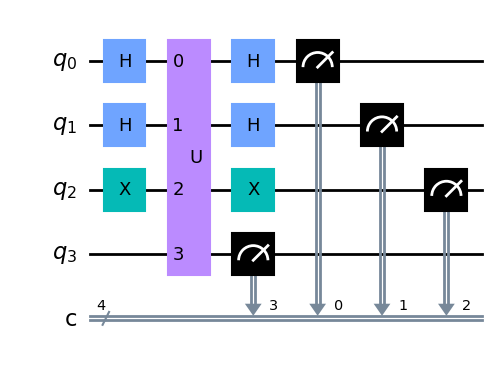

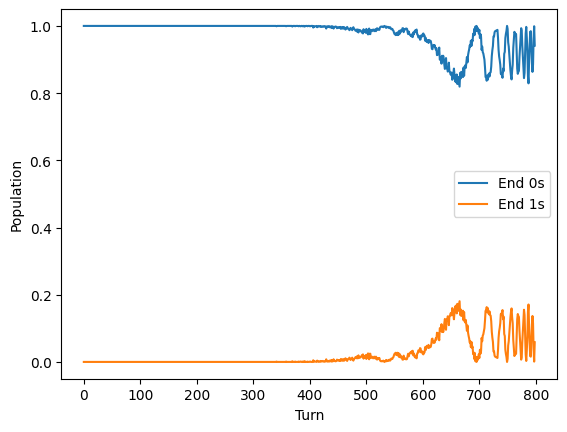

In [ ]:
# end of code
import qiskit.tools.jupyter
%qiskit_version_table